В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся другими частями датасета freMPL (1 и 2).

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
from sklearn.utils import class_weight

pd.set_option('display.max_columns', None)

def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [2]:
df = pd.read_csv('data/freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
df_1 = df.copy()
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,0,72,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,0,80,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,0,63,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,0,72,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


In [5]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0
df.Gender, GenderRef = SeriesFactorizer(df.Gender)
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Female', 1: 'Male'}
{0: 'Other', 1: 'Alone'}


In [6]:
list(df.VehUsage.unique())

['Professional', 'Private+trip to office', 'Private', 'Professional run']

In [7]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [8]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [9]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP9,10
CSP7,55
CSP3,837
CSP2,1476
CSP1,1975
CSP4,3279
CSP6,4885
CSP5,28215


In [10]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [11]:
df = df.select_dtypes(exclude=['object'])

In [12]:
df['DrivAgeSq'] = df.DrivAge.apply(lambda x: x**2)
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,SocioCateg_CSP9,DrivAgeSq
0,0.583,366,0,0,55,0,72,0.000000,15.0,0,0,0,1,0,1,0,0,0,0,0,0,0,3025
1,0.200,187,1,1,34,0,80,0.000000,20.0,0,0,1,0,0,0,0,0,0,1,0,0,0,1156
2,0.083,169,0,0,33,0,63,0.000000,17.0,0,0,0,1,0,1,0,0,0,0,0,0,0,1089
3,0.375,170,0,0,34,0,63,0.000000,17.0,0,0,0,1,0,1,0,0,0,0,0,0,0,1156
4,0.500,224,1,0,53,0,72,1418.610272,19.0,1,0,0,1,0,0,0,0,1,0,0,0,0,2809


In [13]:
df['RiskVar'] = (df['RiskVar'] - 1).astype(int)
df['RiskVar'].unique()

array([14, 19, 16, 18,  9, 15,  0,  7, 17, 10, 13, 12, 11,  8,  5,  2,  6,
        4,  3,  1])

In [14]:
FreqCount = pd.DataFrame(df.groupby('RiskVar').size(), columns=['Count'])
FreqCount['Freq'] = FreqCount['Count'] / FreqCount['Count'].sum()

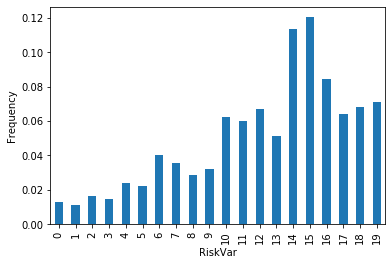

In [15]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [16]:
weights = class_weight.compute_class_weight('balanced',
                                                 df.RiskVar.unique(),
                                                 df.RiskVar)

In [17]:
def make_weight (row):
   return weights[int(row['RiskVar'])]

In [18]:
df['weight'] = df.apply (lambda row: make_weight(row), axis=1)

In [19]:
df.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd,VehUsage_Private,VehUsage_Private+trip to office,VehUsage_Professional,VehUsage_Professional run,SocioCateg_CSP1,SocioCateg_CSP2,SocioCateg_CSP3,SocioCateg_CSP4,SocioCateg_CSP5,SocioCateg_CSP6,SocioCateg_CSP7,SocioCateg_CSP9,DrivAgeSq,weight
0,0.583,366,0,0,55,0,72,0.000000,14,0,0,0,1,0,1,0,0,0,0,0,0,0,3025,2.257871
1,0.200,187,1,1,34,0,80,0.000000,19,0,0,1,0,0,0,0,0,0,1,0,0,0,1156,4.515743
2,0.083,169,0,0,33,0,63,0.000000,16,0,0,0,1,0,1,0,0,0,0,0,0,0,1089,1.246389
3,0.375,170,0,0,34,0,63,0.000000,16,0,0,0,1,0,1,0,0,0,0,0,0,0,1156,1.246389
4,0.500,224,1,0,53,0,72,1418.610272,18,1,0,0,1,0,0,0,0,1,0,0,0,0,2809,3.377446


In [20]:
TARGET = 'RiskVar'

In [21]:
# Разбиение датасета на train/val/test

x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=TARGET, axis=1), df[TARGET], stratify= df[TARGET], test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, stratify= y_test, test_size=0.5, random_state=10)

In [22]:
xgb_train = xgb.DMatrix(data=x_train.drop('weight', axis=1),label= (y_train), weight=x_train['weight'])
xgb_valid = xgb.DMatrix(data=x_valid.drop('weight', axis=1),label= (y_valid), weight=x_train['weight'])
xgb_test =  xgb.DMatrix(data=x_test.drop('weight', axis=1), label= (y_test), weight=x_train['weight'])

In [37]:
params ={
        'alpha': 0.3986441563854538,
        'colsample_bytree': 0.5556413857890639,
        'eta': 0.2037337545723714,
        'eval_metric': 'mlogloss',
        'gpu_id': 0,
        'lambda': 0.837256082412685,
        'max_depth': 12,
        'min_child_weight': 6.157717810193642,
        'num_boost_round': 223.0,
        'num_class': 20,
        'objective': 'multi:softprob',
        'seed': 10,
        'subsample': 0.7790309580091659,
        'tree_method': 'gpu_hist'
        }

model = xgb.train(params,  xgb_train)

[12:24:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_master\src\learner.cc:334: 
Parameters: { num_boost_round } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [24]:
def prepare_result(predictions):
    df_class_preds = pd.DataFrame(predictions)
    return df_class_preds.idxmax(axis=1)

In [25]:
from sklearn.metrics import log_loss

def print_score(model, x_valid, label_valid):
  pred_valid = model.predict(x_valid)
  score = log_loss(label_valid, pred_valid, labels=range(20))
  print(f'Logloss:{score}')
  score = f1_score(label_valid, prepare_result(pred_valid)  , average='micro')
  print(f'f1_score:{score}')

print_score(model, xgb_train, y_train)
print_score(model, xgb_valid, y_valid)

Logloss:1.9640126264265378
f1_score:0.41708754208754206
Logloss:3.083369621563453
f1_score:0.1530278232405892


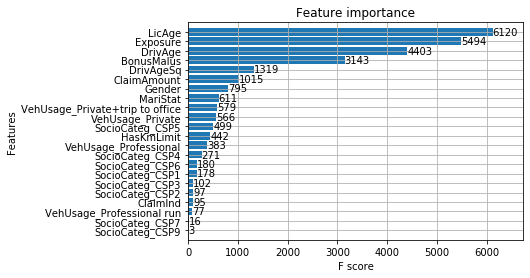

In [26]:
importance_type = ['total_gain', 'gain', 'weight', 'total_cover', 'cover']
xgb.plot_importance(model, height=0.8)
plt.show()

In [27]:
ALL_FEATS=sorted(model.get_fscore().items(), key=lambda x:x[1], reverse=True)
ALL_FEATS

[('LicAge', 6120),
 ('Exposure', 5494),
 ('DrivAge', 4403),
 ('BonusMalus', 3143),
 ('DrivAgeSq', 1319),
 ('ClaimAmount', 1015),
 ('Gender', 795),
 ('MariStat', 611),
 ('VehUsage_Private+trip to office', 579),
 ('VehUsage_Private', 566),
 ('SocioCateg_CSP5', 499),
 ('HasKmLimit', 442),
 ('VehUsage_Professional', 383),
 ('SocioCateg_CSP4', 271),
 ('SocioCateg_CSP6', 180),
 ('SocioCateg_CSP1', 178),
 ('SocioCateg_CSP3', 102),
 ('SocioCateg_CSP2', 97),
 ('ClaimInd', 95),
 ('VehUsage_Professional run', 77),
 ('SocioCateg_CSP7', 16),
 ('SocioCateg_CSP9', 3)]

In [28]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    df_class_preds = pd.DataFrame(y_pred)
    y_pred_max =  df_class_preds.idxmax(axis=1)
    err = 1-f1_score( y_true, y_pred_max, average='micro')    
    return 'f1_err', err

In [29]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    global xgb_train
    parameters = {
        'objective': params[ 'objective'],
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda'],
        'num_class': params[ 'num_class'],
        'eval_metric':params['eval_metric'],
        'seed':params['seed'],
        'gpu_id':params['gpu_id'],
        'tree_method':params['tree_method']
    }
    
    cv_result = xgb.cv(parameters, xgb_train, num_boost_round=int(params['num_boost_round']), nfold=5, seed=10, maximize=False, early_stopping_rounds=10, feval=f1_eval)
    score = cv_result['test-f1_err-mean'][-1:].values[0]
    return score

In [30]:
# Определим границы, в которых будем искать гиперпараметры 

space = {
        'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
        'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
        'min_child_weight': hp.uniform('min_child_weight', 0, 50),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'alpha': hp.uniform('alpha', 0, 1),
        'lambda': hp.uniform('lambda', 0, 1),
        'eta': hp.uniform('eta', 0.01, 1),
        'num_class': 20,
        'objective': 'multi:softprob',
        'eval_metric':'mlogloss',
        'tree_method': 'gpu_hist',
        'seed':10,
        'gpu_id':0
        }

In [31]:
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20)

100%|██████████| 20/20 [55:38<00:00, 166.95s/trial, best loss: 0.819725]          


In [32]:
best_params = space_eval(space, best)
best_params

{'alpha': 0.3986441563854538,
 'colsample_bytree': 0.5556413857890639,
 'eta': 0.2037337545723714,
 'eval_metric': 'mlogloss',
 'gpu_id': 0,
 'lambda': 0.837256082412685,
 'max_depth': 12,
 'min_child_weight': 6.157717810193642,
 'num_boost_round': 223.0,
 'num_class': 20,
 'objective': 'multi:softprob',
 'seed': 10,
 'subsample': 0.7790309580091659,
 'tree_method': 'gpu_hist'}

In [33]:
progress = dict()
xgb_multiclass = xgb.train(num_boost_round=int(best_params.pop('num_boost_round')), params=best_params,  dtrain=xgb_train, feval=f1_eval, maximize=False, evals=[(xgb_train, "train"),(xgb_valid, "valid")], 
                           early_stopping_rounds=15, evals_result=progress, verbose_eval=False)

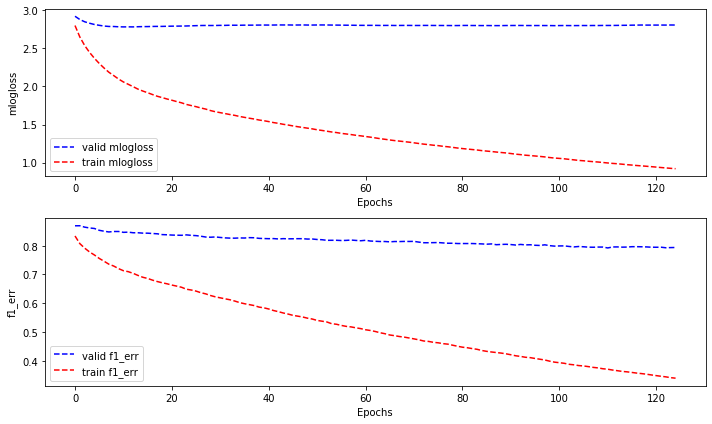

In [34]:
plt.subplots(2,1, figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(progress['valid']['mlogloss'], label='valid mlogloss', linestyle='dashed', color='blue')
plt.plot(progress['train']['mlogloss'], label='train mlogloss', linestyle='dashed', color='red')
plt.xlabel('Epochs'); plt.ylabel('mlogloss'); plt.legend(); plt.tight_layout()
plt.subplot(2,1,2)
plt.plot(progress['valid']['f1_err'], label='valid f1_err', linestyle='dashed', color='blue')
plt.plot(progress['train']['f1_err'], label='train f1_err', linestyle='dashed', color='red')
plt.xlabel('Epochs'); plt.ylabel('f1_err'); plt.legend(); plt.tight_layout()

In [35]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    class_preds =  prepare_result(xgb_multiclass.predict(dfset['dmat']))
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds , average='micro')) 

F1 Score on train: 0.6618616722783389
F1 Score on valid: 0.20572831423895255
F1 Score on test: 0.18527004909983633


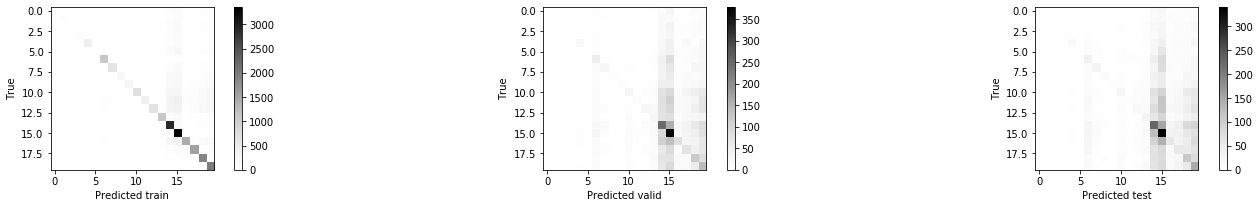

In [36]:
plt.subplots(1,3, figsize=(25,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], prepare_result(xgb_multiclass.predict(dfsets[i]['dmat'])))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted '+ str(dfsets[i]['set']))
plt.show()

О модели:

Модель переобучена - оценка метрики на train сильно отличается от valid и test. При этом графике хорошо видно, как быстро модель на train переобучается. Регулиризация L1 и L2 помогает слабо по найденным параметрам alpha и lambda.
Из-за преобладания классов 14 и 15 (дисбаланс классов), то к ним ошибочно модель относит другие метки, что хорошо видно на матрице. Добавление весовых коэффициентов улучшает метрику, но решает проблему дисбаланса классов не полностью.

In [79]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, jsonify
a = df.sample(n=1).to_json()
print(a)

{"Exposure":{"40090":1.0},"LicAge":{"40090":498},"Gender":{"40090":1},"MariStat":{"40090":0},"DrivAge":{"40090":77},"HasKmLimit":{"40090":0},"BonusMalus":{"40090":50},"ClaimAmount":{"40090":0.0},"RiskVar":{"40090":14},"ClaimInd":{"40090":0},"VehUsage_Private":{"40090":1},"VehUsage_Private+trip to office":{"40090":0},"VehUsage_Professional":{"40090":0},"VehUsage_Professional run":{"40090":0},"SocioCateg_CSP1":{"40090":0},"SocioCateg_CSP2":{"40090":0},"SocioCateg_CSP3":{"40090":0},"SocioCateg_CSP4":{"40090":0},"SocioCateg_CSP5":{"40090":0},"SocioCateg_CSP6":{"40090":1},"SocioCateg_CSP7":{"40090":0},"SocioCateg_CSP9":{"40090":0},"DrivAgeSq":{"40090":5929},"weight":{"40090":2.2578713969}}


In [92]:
# Обработчики и запуск Flask

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

def map_for_dict_Gender(Gender):
  dict_Gender = {'Male':0, 'Female':1}
  res = dict_Gender.get(Gender)
  return res

def map_for_dict_MariStat(MariStat):
  dict_MariStat = {'Other':0, 'Alone':1}
  res = dict_MariStat.get(MariStat)
  return res

def f_VehUsage_Professional(VehUsage):
  if VehUsage == 'Professional':
    VehUsage_Professional = 1
  else:
    VehUsage_Professional = 0
  return(VehUsage_Professional)

def f_VehUsage_Private_trip_to_office(VehUsage):
  if VehUsage == 'Private+trip to office':
    VehUsage_Private_trip_to_office = 1
  else:
    VehUsage_Private_trip_to_office = 0
  return(VehUsage_Private_trip_to_office)

def f_VehUsage_Private(VehUsage):
  if VehUsage == 'Private':
    VehUsage_Private = 1
  else:
    VehUsage_Privatel = 0
  return(VehUsage_Private)

def f_VehUsage_Professional_run(VehUsage):
  if VehUsage == 'Professional run':
    VehUsage_Professional_run = 1
  else:
    VehUsage_Professional_run = 0
  return(VehUsage_Professional_run)

def make_weight (row):
   return weights[int(row['RiskVar'])]


@app.route('/predict', methods=['GET', 'POST'])
def predict3():

    try:

        json_input = request.json

        ID = json_input["ID"]
        LicAge = json_input["LicAge"]
        Gender = map_for_dict_Gender(json_input["Gender"])
        MariStat = map_for_dict_MariStat(json_input["MariStat"])
        DrivAge = json_input["DrivAge"]
        HasKmLimit = json_input["HasKmLimit"]
        BonusMalus = json_input["BonusMalus"]
        VehUsg_Private = f_VehUsage_Private(json_input["VehUsage"])
        VehUsg_Private_trip_to_office = f_VehUsage_Private_trip_to_office(json_input["VehUsage"])
        VehUsg_Professional = f_VehUsage_Professional(json_input["VehUsage"])
        VehUsg_Professional_run = f_VehUsage_Professional_run(json_input["VehUsage"])
        DrivAgeSq = DrivAge ** 2

        X = np.array([[
            LicAge,
            Gender,
            MariStat,
            DrivAge,
            HasKmLimit,
            BonusMalus,
            VehUsg_Private,
            VehUsg_Private_trip_to_office,
            VehUsg_Professional,
            VehUsg_Professional_run,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            DrivAgeSq
        ]])


        columns = [
        'Exposure', 
        'LicAge', 
        'Gender', 
        'MariStat', 
        'DrivAge', 
        'HasKmLimit',
        'BonusMalus', 
        'ClaimAmount',
        'ClaimInd', 
        'VehUsage_Private',
        'VehUsage_Private+trip to office',
        'VehUsage_Professional',
        'VehUsage_Professional run',
        'SocioCateg_CSP1',
        'SocioCateg_CSP2',
        'SocioCateg_CSP3',
        'SocioCateg_CSP4',
        'SocioCateg_CSP5',
        'SocioCateg_CSP6',
        'SocioCateg_CSP7',
        'SocioCateg_CSP9',
        'DrivAgeSq',
        ]



        dtest = xgb.DMatrix(pd.DataFrame(X, columns=columns)) 
        prediction = xgb_multiclass.predict(dtest)
        value = prediction[0]
        return jsonify({'ID': json_input['ID'], 'RiskVar': str(value)})  
    
    except Exception as e:
        print(e)
        return "Error"

In [93]:
if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Feb/2020 13:28:05] "POST /predict HTTP/1.1" 200 -


 * Running on http://b02663a7.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
